- Load necessary module

In [1]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import multinomial
from collections import OrderedDict

- Load model that defined in channel realization

In [2]:
mat = io.loadmat('temp.mat')
model = {}
model['H'] = mat['H']
model['Wopt'] = mat['Wopt']
model['Fopt'] = mat['Fopt']
# model['Ns'] = mat['Ns'][0,0] ## need to change nb of stream in channel realization, this case 1
model['Ns'] = 2
model['Nt'] = mat['Nt'][0,0]
model['Nr'] = mat['Nr'][0,0]
model['Nc'] = mat['Nc'][0,0]
model['Nray'] = mat['Nray'][0,0]
model['realization'] = mat['realization'][0,0]
model['At'] = mat['At']
model['Ar'] = mat['Ar']
model['Nrf'] = 2

In [3]:
for key in model:
    print(key)

H
Wopt
Fopt
Ns
Nt
Nr
Nc
Nray
realization
At
Ar
Nrf


Load values of phase shifter included:
- nb_bit: number of bit
- nb_ps: number of phase shifter in the system
- nb_state: number of state in each phase shifter (2^nb_bit)

# Cross Entropy Beamforming

### Helper function for Cross entropy Beamforming

In [4]:
model['Ns']

2

In [5]:
def phase_shifter(n_bit,n_ant):
    """
    Define phase shifter with N bits resolution
    
    Arguments:
    N -- number of bits resolutions
    
    Returns:
    y -- python dictionnary of phase shifter: index of state and value of phase
    """
    nb_state = 2**n_bit
    w = np.exp(1j*2*np.pi/nb_state)
    ps = np.zeros(nb_state,dtype=complex)
    for i in range(nb_state):
        ps[i] = w**i/np.sqrt(n_ant)
    return np.around(ps, decimals=3)

def generate_candidat(S,model,phase_value,ps_system_proba):
    """
    generate S candidates from the previous pmf
    
    Arguments: 
    S -- Number of candidates to generate
    model -- channel model
    phase_value -- possible phase shifted value
    ps_system_proba -- pmf of phase shifters
    
    Returns
    F_rf -- S analog precoder system
    """
    F_rf = np.zeros((S,model['Nt'],model['Nrf']),dtype=complex)
    for i in range(S):
        for j in range(model['Nt']):
            for k in range(model['Nrf']):
                F_rf[i,j,k] = np.random.choice(phase_value, 1, p=ps_system_proba[j,k,:])
    return F_rf

def compute_Fbb(F_rf,model):
    """
    Compute baseband precoder base on the effective channel (Heq = H*Frf)
    
    Arguments:
    F_rf -- analog precoder
    model -- channel model
    
    Returns:
    F_bb -- S baseband precoder
    """
    S = F_rf.shape[0]
    channel_eq = np.zeros((S,model['Nr'],model['Nrf']),dtype=complex)
    F_bb = np.zeros((S,model['Nrf'],model['Ns']),dtype=complex)
    channel_index = 0 ### need to adjust 
    for i in range(S):
        channel_eq[i,:,:] =  model['H'][:,:,channel_index]@F_rf[i,:,:]
        U, s, V = np.linalg.svd(channel_eq[i,:,:], full_matrices=True)
        V = V.conj().T
        F_bb[i,:,:] = V[0:model['Nt'],0:model['Ns']]
        F_bb[i,:,:] = np.sqrt(model['Ns'])*F_bb[i,:,:]/np.linalg.norm(F_rf[i,:,:]@F_bb[i,:,:],'fro')
    return F_bb

def optimal_beamformer(model, channel_index):
    """
    Compute the optimal beamformer by SVD
    
    Arguments:
    model -- channel model
    channel_index -- index in 1000 realization channel
    
    Returns:
    Fopt -- optimal precoder
    Wopt -- optimal combiner
    """
    Wopt = np.zeros((model['Nr'],model['Ns']),dtype=complex)
    Fopt = np.zeros((model['Nt'],model['Ns']),dtype=complex)
    U, s, V = np.linalg.svd(model['H'][:,:,channel_index], full_matrices=True)
    V = V.conj().T
    Fopt = V[0:model['Nt'],0:model['Ns']]
    Wopt = U[0:model['Nr'],0:model['Ns']]
    return Fopt, Wopt


def update_pmf(F_elites,phase_value,nb_elite):
    """
    Update new phase shifters's pmf base on previous candidates's results
    
    Arguments:
    F_elites -- elites analog precoder
    phase_value -- phase shift value
    nb_elite -- number of elites 
    
    Returns:
    ps_system_proba -- pmf of phase shifter
    """
    alpha = 0.9
    nb_state = phase_value.shape[0]
    stat_count = np.zeros(nb_state)
    for i in range(model['Nt']):
        for j in range(model['Nrf']):
            unique, counts = np.unique(F_elites[:,i,j], return_counts=True)
            value_count = dict(zip(unique, counts))
            for k in range(nb_state):
                if phase_value[k] in value_count:   
                    proba_est = value_count[phase_value[k]]/nb_elite
                else:
                    proba_est = 0
                ps_system_proba[i,j,k] = alpha*proba_est + (1-alpha)*ps_system_proba[i,j,k] 
    return ps_system_proba

def data_rate(Ns,SNR,W,H,F):
    """
    Compute the data rate of the beamforming system
    
    Arguments:
    Ns -- number of stream
    SNR -- Signal to noise ratio
    W -- combiner
    H -- channel
    F -- precoder
    
    Returns:
    R -- data rate
    """
    R = np.log2(np.linalg.det(np.eye(Ns)+SNR/Ns*np.linalg.pinv(W)@H@F@F.conj().T@H.conj().T@W))
    return R.real

### Define Phase shiter

In [6]:
nb_bit = 2
nb_ps = model['Nt']*model['Nrf']
nb_ps
nb_state = 2**nb_bit

In [7]:
phase_value = phase_shifter(nb_bit,model['Nt'])
phase_value

array([ 0.125+0.   j,  0.   +0.125j, -0.125+0.   j, -0.   -0.125j])

Phase shifter system dimension is: NtxNrfxN_state

### Cross entropy beamforming Algorithm
 Step 1: Randomly generate S candidate analog beamformers

 Step 2: Compute S corresponding digital precoders Fbb based on the effective channel Heq = HFrf

 Step 3: Calculate the achievable sum-rate

 Step 4: Sort R in a descend order

 Step 5: Select elites as Frf_1, Frf_2, ..., Frf_elite

 Step 6: Update new pmf for each phase shifter

In [8]:
nb_elite = 40
S = 200
channel_index = 0
Fopt, Wopt = optimal_beamformer(model,channel_index)
nb_iterate = 30
ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
# R_max = np.zeros((nb_iterate))
proba_evo = np.copy(ps_system_proba[0,0,:])
print(proba_evo)
i = 0
relative_std = 1000 # initialize high value of relative standard deviation
SNR = 10**(10/10)
while ((i<nb_iterate) and (relative_std>3)):
    print(i)
    F_rf = generate_candidat(S,model,phase_value,ps_system_proba)
    F_bb = compute_Fbb(F_rf,model)
    R = np.zeros((S))
    for j in range(S):
        R[j] = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],F_rf[j,:,:]@F_bb[j,:,:])
#         R[j] = np.log2(np.linalg.det(np.eye(model['Ns']))+SNR/model['Ns']*np.linalg.pinv(Wopt)@model['H'][:,:,channel_index]@F_rf[j,:,:]@F_bb[j,:,:]@F_bb[j,:,:].conj().T@F_rf[j,:,:].conj().T@model['H'][:,:,channel_index].conj().T@Wopt).real
    R_sort_index = np.argsort(R)[::-1][:nb_elite]
    if i==0:
        R_max = R[R_sort_index[0]]
    else:
        R_max = np.append(R_max,R[R_sort_index[0]])
    F_elites = F_rf[R_sort_index,:,:]
    Frf_max = F_rf[R_sort_index[0],:,:]
    Fbb_max = F_bb[R_sort_index[0],:,:]
    ps_system_proba = update_pmf(F_elites,phase_value,nb_elite)
    proba_evo = np.vstack((proba_evo,ps_system_proba[0,0,:]))
    if i>=5:
        R_max_normalize = R_max-np.min(R_max) ## Need to review
        relative_std = 100*np.std(R_max_normalize[i-5:i])/np.mean(R_max_normalize[i-5:i])
        print(relative_std)
    i +=1
    

[0.25 0.25 0.25 0.25]
0
1
2
3
4
5
103.38618900933675
6
80.58011096006454
7
68.94763551694557
8
54.15643502020425
9
36.46933118497604
10
27.689929174986794
11
19.792781189025916
12
16.173064541116798
13
11.508045791525936
14
8.063105424550196
15
5.6788107833391805
16
5.828684916634461
17
4.563090898184828
18
4.278472153806928
19
3.280704752443115
20
2.158496724360242


In [9]:
# Evolution of pmf of 1 phase shifter
np.around(proba_evo, decimals=3)

array([[0.25 , 0.25 , 0.25 , 0.25 ],
       [0.272, 0.228, 0.228, 0.272],
       [0.252, 0.248, 0.158, 0.342],
       [0.183, 0.317, 0.218, 0.282],
       [0.243, 0.324, 0.202, 0.231],
       [0.204, 0.37 , 0.11 , 0.316],
       [0.088, 0.329, 0.146, 0.437],
       [0.121, 0.303, 0.15 , 0.426],
       [0.102, 0.255, 0.15 , 0.493],
       [0.078, 0.318, 0.127, 0.477],
       [0.075, 0.234, 0.17 , 0.52 ],
       [0.053, 0.158, 0.22 , 0.57 ],
       [0.05 , 0.173, 0.292, 0.484],
       [0.073, 0.152, 0.299, 0.476],
       [0.097, 0.083, 0.232, 0.588],
       [0.01 , 0.053, 0.181, 0.756],
       [0.023, 0.005, 0.153, 0.818],
       [0.002, 0.001, 0.083, 0.914],
       [0.   , 0.   , 0.031, 0.969],
       [0.   , 0.   , 0.026, 0.974],
       [0.   , 0.   , 0.003, 0.997],
       [0.   , 0.   , 0.   , 1.   ]])

In [10]:
proba_evo.shape

(22, 4)

[12.74894194 12.83187379 13.16275153 13.13392866 13.98723905 14.51788894
 15.58085834 15.88260067 16.56351199 17.09372154 17.62103609 17.71039579
 18.11297592 18.23360091 18.39128269 18.67700116 18.79985204 18.89947507
 18.93653798 19.07057769 19.08635491]


Text(0.5,0,'iteration')

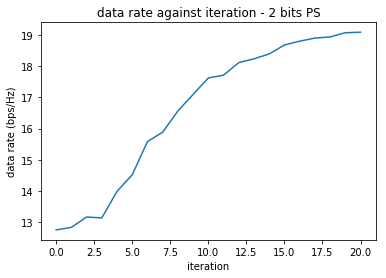

In [11]:
print(R_max)
plt.plot(R_max)
plt.title('data rate against iteration - 2 bits PS')
plt.ylabel('data rate (bps/Hz)')
plt.xlabel('iteration')

Test:

2 bits -- 17.56 bps/Hz - 16 iterate

3 bits -- 17.68 bps/Hz - 18 iterate

4 bits -- 17.71 bps/Hz - 18 iterate

6 bits -- 17.68 bps/Hz - 19 iterate

# Digital Beamforming

In [12]:
R_o = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],Fopt)
print(R_o)

20.41756613013491


In [13]:
# Normalize condition
x = np.linalg.norm(F_rf[1,:,:]@F_bb[1,:,:],'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

Ns 2    Frobenius norm FRF*FBB= 1.9999999999999996


In [14]:
Wopt.shape

(16, 2)

# OMP Beamforming

In [15]:
def OMP(_Fopt,_NRF,_At):
    _FRF = np.empty((_At.shape[0],0))
    _Fres = _Fopt
    for k in range(_NRF):
        PU = _At.conj().T@_Fres
        ind = np.argmax(np.sum((np.absolute(PU))**2,axis=1))
        _FRF = np.append(_FRF,_At[:,[ind]],axis=1)
        _FBB = (np.linalg.pinv(_FRF))@_Fopt
        _Fres = (_Fopt-_FRF@_FBB)/np.linalg.norm((_Fopt-_FRF@_FBB),'fro')
#         _Fres = (_Fopt-_FRF@_FBB)
    return _FRF,_FBB

In [16]:
FRF_omp, FBB_omp = OMP( Fopt, model['Nrf'], model['At'][:,:,channel_index] ) 

In [17]:
R_omp = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],FRF_omp@FBB_omp)
print(R_omp)

16.7201107591366


In [18]:
FRF_omp.shape

(64, 2)

In [19]:
Frf_max

array([[-0.   -0.125j,  0.125+0.   j],
       [ 0.   +0.125j, -0.125+0.   j],
       [-0.125+0.   j,  0.   +0.125j],
       [ 0.125+0.   j, -0.125+0.   j],
       [ 0.   +0.125j,  0.125+0.   j],
       [ 0.125+0.   j, -0.125+0.   j],
       [-0.125+0.   j,  0.125+0.   j],
       [ 0.125+0.   j, -0.125+0.   j],
       [ 0.125+0.   j,  0.   +0.125j],
       [-0.125+0.   j, -0.   -0.125j],
       [ 0.125+0.   j,  0.   +0.125j],
       [-0.125+0.   j, -0.125+0.   j],
       [ 0.   +0.125j,  0.125+0.   j],
       [ 0.125+0.   j, -0.125+0.   j],
       [-0.125+0.   j,  0.125+0.   j],
       [ 0.125+0.   j, -0.125+0.   j],
       [ 0.   +0.125j,  0.   +0.125j],
       [-0.   -0.125j, -0.   -0.125j],
       [ 0.125+0.   j,  0.   +0.125j],
       [-0.125+0.   j, -0.   -0.125j],
       [ 0.   +0.125j,  0.125+0.   j],
       [-0.   -0.125j, -0.125+0.   j],
       [-0.125+0.   j,  0.125+0.   j],
       [ 0.125+0.   j, -0.125+0.   j],
       [ 0.   +0.125j,  0.   +0.125j],
       [-0.   -0.125j,  0

### Quantize omp beamforming

In [20]:
def quantize_Frf(model,n_bit,F_rf,channel_index):
    q = 2*np.pi/2**n_bit
    amplitude = 1/np.sqrt(model['Nt'])
    Frf_angle = np.angle(F_rf)
    angle_quantized = q * np.round(Frf_angle/q)
    Frf_quantized = amplitude*np.exp(1j*angle_quantized)
    Frf_quantized = np.around(Frf_quantized, decimals=3)
    
    channel_eq =  model['H'][:,:,channel_index]@Frf_quantized
    U, s, V = np.linalg.svd(channel_eq, full_matrices=True)
    V = V.conj().T
    F_bb = V[0:model['Nt'],0:model['Ns']]
    F_bb = np.sqrt(model['Ns'])*F_bb/np.linalg.norm(Frf_quantized@F_bb,'fro')
    
    return Frf_quantized, F_bb

In [21]:
Frf_quantize, Fbb_quantize = quantize_Frf(model,nb_bit,FRF_omp,channel_index)

In [22]:
Fbb_quantize

array([[-0.98438001+0.        j, -0.17605677+0.        j],
       [ 0.06092777+0.16517807j, -0.34066329-0.9235543 j]])

In [23]:
R_omp_quantized = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],Frf_quantize@Fbb_quantize)
print(R_omp_quantized)

17.96717163142237


In [24]:
# Normalize condition
x = np.linalg.norm(Frf_quantize@Fbb_quantize,'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

Ns 2    Frobenius norm FRF*FBB= 2.0000000000000004


### Initialize pmf with OMP

In [25]:
ps_system_proba.shape

(64, 2, 4)

In [26]:
np.around(ps_system_proba, decimals=3).shape

(64, 2, 4)

In [27]:
phase_value

array([ 0.125+0.   j,  0.   +0.125j, -0.125+0.   j, -0.   -0.125j])

In [28]:
Frf_quantize

array([[ 0.125+0.   j,  0.125+0.   j],
       [-0.125+0.   j, -0.125-0.   j],
       [ 0.125+0.   j,  0.   +0.125j],
       [-0.125+0.   j,  0.   -0.125j],
       [ 0.125+0.   j, -0.125+0.   j],
       [-0.125+0.   j,  0.125+0.   j],
       [ 0.125+0.   j,  0.   -0.125j],
       [-0.125+0.   j,  0.   +0.125j],
       [ 0.125+0.   j,  0.125+0.   j],
       [-0.125-0.   j, -0.125-0.   j],
       [ 0.125+0.   j,  0.   +0.125j],
       [-0.125-0.   j,  0.   -0.125j],
       [ 0.125+0.   j, -0.125+0.   j],
       [-0.125-0.   j,  0.125+0.   j],
       [ 0.125+0.   j, -0.125-0.   j],
       [-0.125-0.   j,  0.   +0.125j],
       [ 0.125+0.   j,  0.125+0.   j],
       [-0.125-0.   j, -0.125-0.   j],
       [ 0.125+0.   j,  0.   +0.125j],
       [-0.125-0.   j,  0.   -0.125j],
       [ 0.125+0.   j, -0.125+0.   j],
       [-0.125-0.   j,  0.125+0.   j],
       [ 0.125+0.   j, -0.125-0.   j],
       [-0.125-0.   j,  0.   +0.125j],
       [ 0.125+0.   j,  0.125+0.   j],
       [-0.125-0.   j, -0

In [29]:
def initialize_pmf_omp(model,nb_bit,Frf_omp_quantize,phase_value,ratio):
    low_proba = 1/(2**nb_bit-1+ratio)
    high_proba = ratio*low_proba
    proba_init = np.zeros((model['Nt'],model['Nrf'],2**nb_bit))
    for i in range(phase_value.shape[0]):
        assign = Frf_quantize == phase_value[i]
        proba_init[:,:,i] = assign*high_proba + np.invert(assign)*low_proba
    return proba_init

In [30]:
test = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,2)
print(test)

[[[0.4 0.2 0.2 0.2]
  [0.4 0.2 0.2 0.2]]

 [[0.2 0.2 0.4 0.2]
  [0.2 0.2 0.4 0.2]]

 [[0.4 0.2 0.2 0.2]
  [0.2 0.4 0.2 0.2]]

 [[0.2 0.2 0.4 0.2]
  [0.2 0.2 0.2 0.4]]

 [[0.4 0.2 0.2 0.2]
  [0.2 0.2 0.4 0.2]]

 [[0.2 0.2 0.4 0.2]
  [0.4 0.2 0.2 0.2]]

 [[0.4 0.2 0.2 0.2]
  [0.2 0.2 0.2 0.4]]

 [[0.2 0.2 0.4 0.2]
  [0.2 0.4 0.2 0.2]]

 [[0.4 0.2 0.2 0.2]
  [0.4 0.2 0.2 0.2]]

 [[0.2 0.2 0.4 0.2]
  [0.2 0.2 0.4 0.2]]

 [[0.4 0.2 0.2 0.2]
  [0.2 0.4 0.2 0.2]]

 [[0.2 0.2 0.4 0.2]
  [0.2 0.2 0.2 0.4]]

 [[0.4 0.2 0.2 0.2]
  [0.2 0.2 0.4 0.2]]

 [[0.2 0.2 0.4 0.2]
  [0.4 0.2 0.2 0.2]]

 [[0.4 0.2 0.2 0.2]
  [0.2 0.2 0.4 0.2]]

 [[0.2 0.2 0.4 0.2]
  [0.2 0.4 0.2 0.2]]

 [[0.4 0.2 0.2 0.2]
  [0.4 0.2 0.2 0.2]]

 [[0.2 0.2 0.4 0.2]
  [0.2 0.2 0.4 0.2]]

 [[0.4 0.2 0.2 0.2]
  [0.2 0.4 0.2 0.2]]

 [[0.2 0.2 0.4 0.2]
  [0.2 0.2 0.2 0.4]]

 [[0.4 0.2 0.2 0.2]
  [0.2 0.2 0.4 0.2]]

 [[0.2 0.2 0.4 0.2]
  [0.4 0.2 0.2 0.2]]

 [[0.4 0.2 0.2 0.2]
  [0.2 0.2 0.4 0.2]]

 [[0.2 0.2 0.4 0.2]
  [0.2 0.4 0.2

In [31]:
nb_elite = 40
S = 200
channel_index = 0
Fopt, Wopt = optimal_beamformer(model,channel_index)
nb_iterate = 30
ps_system_proba = initialize_pmf_omp(model,nb_bit,Frf_quantize,phase_value,2)
# R_max = np.zeros((nb_iterate))
proba_evo = np.copy(ps_system_proba[0,0,:])
print(proba_evo)
i = 0
relative_std = 1000 # initialize high value of relative standard deviation
SNR = 10**(10/10)
while ((i<nb_iterate) and (relative_std>3)):
    print(i)
    F_rf = generate_candidat(S,model,phase_value,ps_system_proba)
    F_bb = compute_Fbb(F_rf,model)
    R = np.zeros((S))
    for j in range(S):
        R[j] = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],F_rf[j,:,:]@F_bb[j,:,:])
#         R[j] = np.log2(np.linalg.det(np.eye(model['Ns']))+SNR/model['Ns']*np.linalg.pinv(Wopt)@model['H'][:,:,channel_index]@F_rf[j,:,:]@F_bb[j,:,:]@F_bb[j,:,:].conj().T@F_rf[j,:,:].conj().T@model['H'][:,:,channel_index].conj().T@Wopt).real
    R_sort_index = np.argsort(R)[::-1][:nb_elite]
    if i==0:
        R_max = R[R_sort_index[0]]
    else:
        R_max = np.append(R_max,R[R_sort_index[0]])
    F_elites = F_rf[R_sort_index,:,:]
    Frf_max = F_rf[R_sort_index[0],:,:]
    Fbb_max = F_bb[R_sort_index[0],:,:]
    ps_system_proba = update_pmf(F_elites,phase_value,nb_elite)
    proba_evo = np.vstack((proba_evo,ps_system_proba[0,0,:]))
    if i>=5:
        R_max_normalize = R_max-np.min(R_max) ## Need to review
        relative_std = 100*np.std(R_max_normalize[i-5:i])/np.mean(R_max_normalize[i-5:i])
        print(relative_std)
    i +=1

[0.4 0.2 0.2 0.2]
0
1
2
3
4
5
61.847596516455425
6
32.40738378387935
7
23.094178357754846
8
17.337927325699052
9
12.320366886547877
10
9.736897680800318
11
5.574215718425017
12
5.491160200496451
13
4.004028320413782
14
3.8912442195519996
15
3.0976528422949303
16
2.5080911607216807


[13.82254405 15.04123561 15.91398921 16.39925329 17.08741803 17.29891452
 17.98436772 18.06548621 18.36696224 18.46656221 18.65492425 18.81309131
 18.86568226 19.03227015 19.09322389 19.1474967  19.1984228 ]


Text(0.5,0,'iteration')

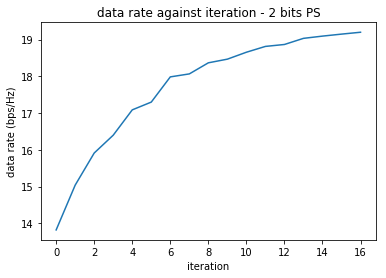

In [32]:
print(R_max)
plt.plot(R_max)
plt.title('data rate against iteration - 2 bits PS')
plt.ylabel('data rate (bps/Hz)')
plt.xlabel('iteration')